<div class="usecase-title">Evaluating Public Transport Accessibility to Places of Interest in Melbourne</div>

<div class="usecase-authors"><b>Authored by: </b> Emmanuel Clement Anthony</div>

<div class="usecase-duration"><b>Duration:</b> {90} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>{Intermediate}</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>{Python}</div>
</div>

<div class="usecase-section-header">Scenario</div>

As a: City Planner

I want: To assess and improve the accessibility of public transport (bus, tram, and train services) to key landmarks in Melbourne

So that: Residents and visitors can easily access important places of interest, leading to better connectivity, increased tourism, and enhanced quality of life.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Cleaning and preprocessing data to ensure accuracy and consistency.
- Calculating distances between landmarks and various public transport stops.
- Developing an accessibility index to quantify the ease of access to public transport for each landmark.
- Visualizing data distributions and geographic patterns using histograms, scatter plots, and pair plots.
- Conducting correlation analysis to understand relationships between different transport modes.
- Applying clustering algorithms (e.g., KMeans) to group landmarks based on accessibility profiles.
- Identifying gaps in public transport coverage and providing actionable recommendations.
- Creating informative visualizations to communicate findings.

<div class="usecase-section-header">Description</div>

The City of Melbourne has numerous landmarks that attract residents and tourists alike. However, the current public transport services might not adequately serve all these key places of interest. By analyzing the proximity and accessibility of train stations, tram stops, and bus stops to these landmarks, we can identify areas where public transport coverage is insufficient. The goal is to provide actionable insights and recommendations for city planners and transport authorities to improve public transport connectivity. This will ensure that all significant landmarks are easily reachable, promoting a more integrated and efficient public transport network throughout the city.


In [28]:
import numpy as np
import pandas as pd
from io import StringIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame

In [4]:
def API_Unlimited(datasetname, apikey): 
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    format = 'csv'

    url = f'{base_url}{datasetname}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        df = pd.read_csv(StringIO(url_content), delimiter=';')
        print(df.sample(10, random_state=999))
        return df
    else:
        print(f'Request failed with status code {response.status_code}')
        return None

apikey = ''
datasets = {
    "landmarks": "landmarks-and-places-of-interest-including-schools-theatres-health-services-spor",
    "bus_stops": "bus-stops",
    "tram_stops": "city-circle-tram-stops",
    "train_stations": "metro-train-stations-with-accessibility-information"
}

#datasets
landmarks_df = API_Unlimited(datasets['landmarks'], apikey)
bus_stops_df = API_Unlimited(datasets['bus_stops'], apikey)
tram_stops_df = API_Unlimited(datasets['tram_stops'], apikey)
train_stations_df = API_Unlimited(datasets['train_stations'], apikey)

                         theme  \
30                      Office   
18                   Mixed Use   
154         Leisure/Recreation   
73          Leisure/Recreation   
20               Community Use   
195          Place Of Assembly   
165           Place of Worship   
125              Community Use   
85   Residential Accommodation   
54                   Transport   

                                           sub_theme  \
30                                            Office   
18                                     Retail/Office   
154                            Gymnasium/Health Club   
73   Informal Outdoor Facility (Park/Garden/Reserve)   
20                               Government Building   
195            Function/Conference/Exhibition Centre   
165                                           Church   
125                                 Public Buildings   
85                                  Dwelling (House)   
54                                   Railway Station   

        

# Data Preparation and Cleaning

In [5]:
#Function to display basic information about a DataFrame
def explore_data(df, name):
    print(f"\n{name} DataFrame Info:")
    print(df.info())
    print(f"\n{name} DataFrame Description:")
    print(df.describe())
    print(f"\n{name} DataFrame Head:")
    print(df.head())
    print(f"\n{name} DataFrame Sample:")
    print(df.sample(5))

# Explore each dataset
if landmarks_df is not None:
    explore_data(landmarks_df, "Landmarks")

if bus_stops_df is not None:
    explore_data(bus_stops_df, "Bus Stops")

if tram_stops_df is not None:
    explore_data(tram_stops_df, "Tram Stops")

if train_stations_df is not None:
    explore_data(train_stations_df, "Train Stations")




Landmarks DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   theme         242 non-null    object
 1   sub_theme     242 non-null    object
 2   feature_name  242 non-null    object
 3   co_ordinates  242 non-null    object
dtypes: object(4)
memory usage: 7.7+ KB
None

Landmarks DataFrame Description:
                     theme                                        sub_theme  \
count                  242                                              242   
unique                  16                                               49   
top     Leisure/Recreation  Informal Outdoor Facility (Park/Garden/Reserve)   
freq                    63                                               37   

                             feature_name                         co_ordinates  
count                                 242                    

In [6]:
#using Landmarks DataFrame to parse coordinates
def parse_coordinates(df, coord_col):
    #Splitting the 'co_ordinates' column into two columns
    df[['latitude', 'longitude']] = df[coord_col].str.split(', ', expand=True)
    df['latitude'] = pd.to_numeric(df['latitude'])
    df['longitude'] = pd.to_numeric(df['longitude'])
    return df

landmarks_df = parse_coordinates(landmarks_df, 'co_ordinates')
print(landmarks_df.head())


              theme sub_theme                 feature_name  \
0  Place of Worship    Church            St Francis Church   
1  Place of Worship    Church              St James Church   
2  Place of Worship    Church    St Mary's Anglican Church   
3  Place of Worship    Church                 Scots Church   
4  Place of Worship    Church  St Michael's Uniting Church   

                          co_ordinates   latitude   longitude  
0  -37.8118847831837, 144.962422614541 -37.811885  144.962423  
1  -37.8101281201969, 144.952468571683 -37.810128  144.952469  
2  -37.8031663672997, 144.953761537074 -37.803166  144.953762  
3   -37.8145687802664, 144.96855105335 -37.814569  144.968551  
4  -37.8143851324913, 144.969174036096 -37.814385  144.969174  


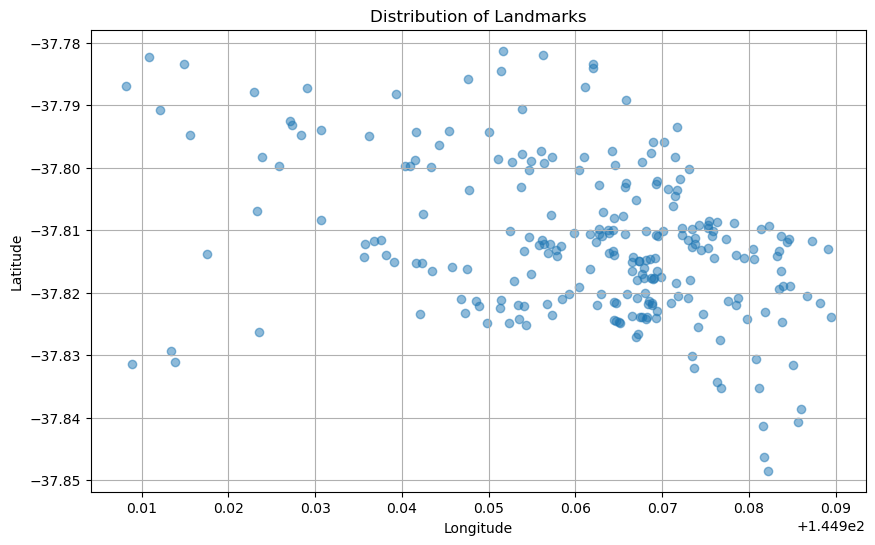

In [7]:
def plot_geographic_data(df, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['longitude'], df['latitude'], alpha=0.5)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

#Plotting data for landmarks
plot_geographic_data(landmarks_df, 'Distribution of Landmarks')


In [8]:
def parse_coordinates(df, coord_col):
    df[['latitude', 'longitude']] = df[coord_col].str.split(', ', expand=True)
    df['latitude'] = pd.to_numeric(df['latitude'])
    df['longitude'] = pd.to_numeric(df['longitude'])
    return df
bus_stops_df = parse_coordinates(bus_stops_df, 'geo_point_2d')
print(bus_stops_df[['latitude', 'longitude']].head())


    latitude   longitude
0 -37.803842  144.932393
1 -37.815487  144.958179
2 -37.813539  144.957283
3 -37.821914  144.955393
4 -37.833164  144.974437


In [9]:
bus_stops_df.drop(columns=['asset_subt'], inplace=True)

In [10]:
bus_stops_df.head()

,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,model_desc,mcc_id,roadseg_id,descriptio,model_no,latitude,longitude
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16,-37.803842,144.932393
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16,-37.815487,144.958179
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16,-37.813539,144.957283
3,"-37.82191394843844, 144.95539345270072","{""coordinates"": [144.95539345270072, -37.82191...",0,15.860434,181,Signage,Sign - Public Transport,918,1232777,103975,Sign - Public Transport 1 Panel,1232777,22174,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16,-37.821914,144.955393
4,"-37.83316401267591, 144.97443745130263","{""coordinates"": [144.97443745130263, -37.83316...",0,0.000000,0,Signage,Sign - Public Transport,1029,1271914,0,Sign - Public Transport 1 Panel,1271914,22708,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16,-37.833164,144.974437


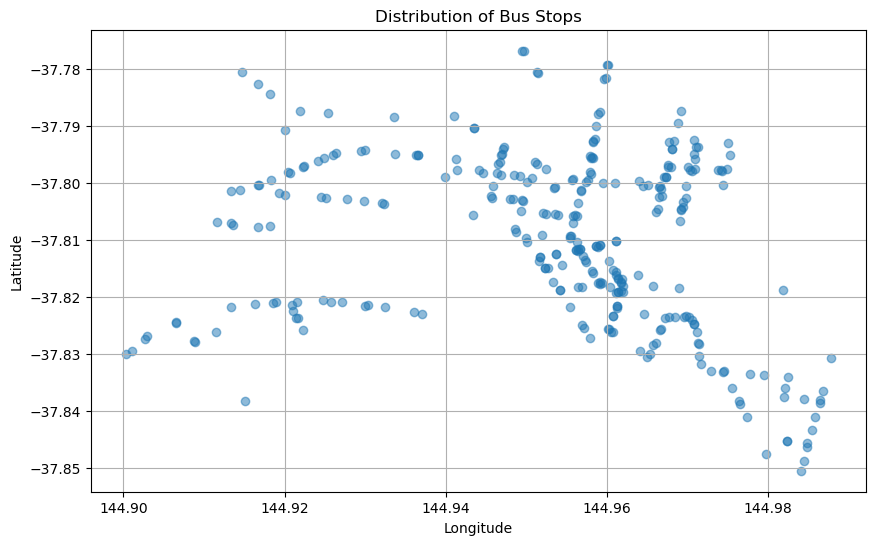

In [11]:
#Plotting data for Bus Stops.
plot_geographic_data(bus_stops_df, 'Distribution of Bus Stops')

In [12]:
print(bus_stops_df.isnull().sum())

#Data type verification
print(bus_stops_df.dtypes)

geo_point_2d    0
geo_shape       0
prop_id         0
addresspt1      0
addressp_1      0
asset_clas      0
asset_type      0
objectid        0
str_id          0
addresspt       0
model_desc      0
mcc_id          0
roadseg_id      0
descriptio      0
model_no        0
latitude        0
longitude       0
dtype: int64
geo_point_2d     object
geo_shape        object
prop_id           int64
addresspt1      float64
addressp_1        int64
asset_clas       object
asset_type       object
objectid          int64
str_id            int64
addresspt         int64
model_desc       object
mcc_id            int64
roadseg_id        int64
descriptio       object
model_no         object
latitude        float64
longitude       float64
dtype: object


In [13]:
#Applying the same coordinate parsing function
tram_stops_df = parse_coordinates(tram_stops_df, 'geo_point_2d')
print(tram_stops_df[['latitude', 'longitude']].head())

    latitude   longitude
0 -37.819223  144.961401
1 -37.821539  144.953569
2 -37.815427  144.945121
3 -37.813415  144.941378
4 -37.814592  144.946551


In [14]:
tram_stops_df.drop(columns=['mccid_str'], inplace=True)

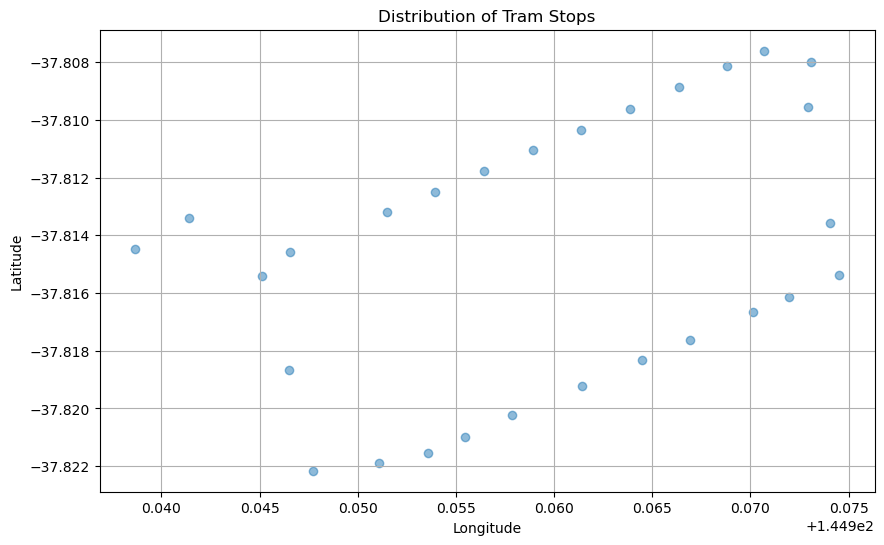

In [15]:
plot_geographic_data(tram_stops_df, 'Distribution of Tram Stops')

In [16]:
print(tram_stops_df.isnull().sum())
#Data type verification
print(tram_stops_df.dtypes)

geo_point_2d    0
geo_shape       0
name            0
xorg            0
stop_no         0
xsource         0
xdate           0
mccid_int       0
latitude        0
longitude       0
dtype: int64
geo_point_2d     object
geo_shape        object
name             object
xorg             object
stop_no          object
xsource          object
xdate            object
mccid_int         int64
latitude        float64
longitude       float64
dtype: object


In [17]:
#Applying the coordinate parsing function to Train Stations DataFrame
train_stations_df = parse_coordinates(train_stations_df, 'geo_point_2d')
print(train_stations_df[['latitude', 'longitude']].head())

    latitude   longitude
0 -37.778396  145.031251
1 -37.867249  144.830604
2 -37.761898  144.960561
3 -37.822411  145.045617
4 -37.733459  144.962747


In [18]:
print(train_stations_df[['he_loop', 'lift', 'pids']].describe())

       he_loop lift        pids
count      219  219         219
unique       3    2           4
top         No   No  Dot Matrix
freq       190  185         115


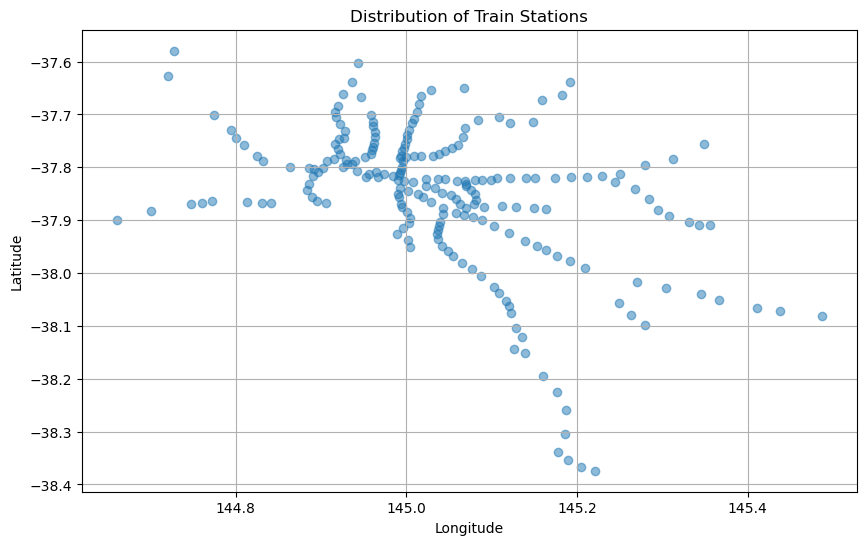

In [19]:
plot_geographic_data(train_stations_df, 'Distribution of Train Stations')

In [20]:
print(train_stations_df.isnull().sum())
#Data type verification
print(train_stations_df.dtypes)

geo_point_2d    0
geo_shape       0
he_loop         0
lift            0
pids            0
station         0
latitude        0
longitude       0
dtype: int64
geo_point_2d     object
geo_shape        object
he_loop          object
lift             object
pids             object
station          object
latitude        float64
longitude       float64
dtype: object


# Feature Engineering

In [21]:
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

def calculate_distances(df1, df2):
    min_distances = []
    for i, row1 in df1.iterrows():
        min_distance = np.inf
        for j, row2 in df2.iterrows():
            distance = haversine(row1['longitude'], row1['latitude'], row2['longitude'], row2['latitude'])
            if distance < min_distance:
                min_distance = distance
        min_distances.append(min_distance)
    return min_distances

#Calculating nearest distances for each type of transport
landmarks_df['nearest_bus_distance'] = calculate_distances(landmarks_df, bus_stops_df)
landmarks_df['nearest_tram_distance'] = calculate_distances(landmarks_df, tram_stops_df)
landmarks_df['nearest_train_distance'] = calculate_distances(landmarks_df, train_stations_df)

In [22]:
#Calculating accessibility index
def calculate_accessibility_index(row):
    weights = {'bus': 0.4, 'tram': 0.4, 'train': 0.2}
    index = (weights['bus'] / (row['nearest_bus_distance'] + 0.1) +  # Avoid division by zero
             weights['tram'] / (row['nearest_tram_distance'] + 0.1) +
             weights['train'] / (row['nearest_train_distance'] + 0.1))
    return index * 1000  #Scaling factor for better interpretation

landmarks_df['accessibility_index'] = landmarks_df.apply(calculate_accessibility_index, axis=1)

#  Exploratory Data Analysis (EDA)

### Correlation Analysis

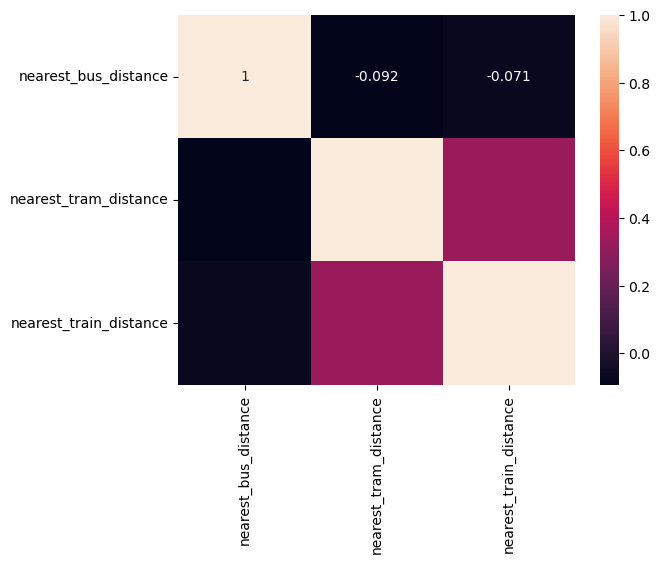

C:\Users\emman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\emman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\emman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


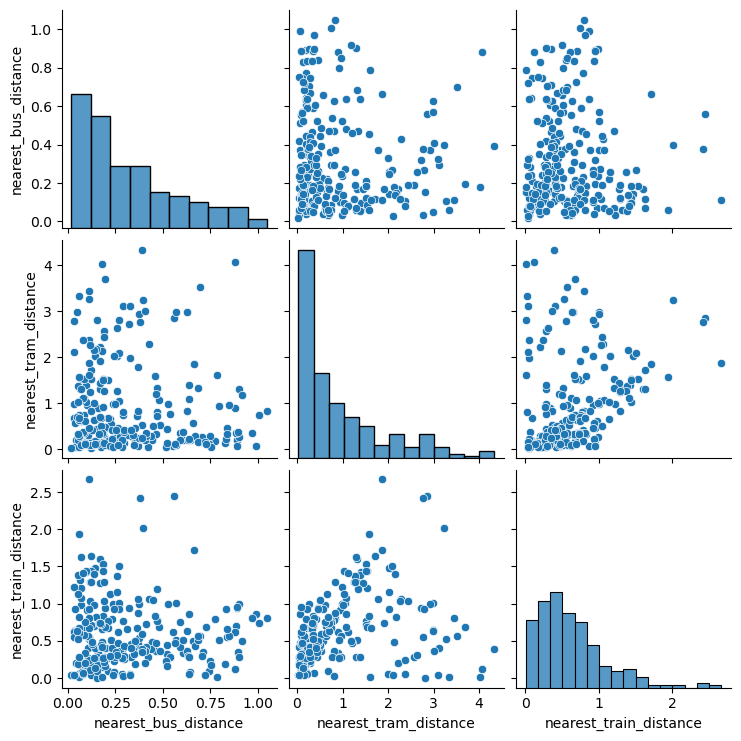

In [24]:
sns.heatmap(landmarks_df[['nearest_bus_distance', 'nearest_tram_distance', 'nearest_train_distance']].corr(), annot=True)
plt.show()

#Further EDA
sns.pairplot(landmarks_df, vars=['nearest_bus_distance', 'nearest_tram_distance', 'nearest_train_distance'])
plt.show()

### Analysis of the Correlation Matrix
#### Observations:

Diagonal Elements:

Each diagonal value is 1, signifying that each distance measure is perfectly correlated with itself.

Correlation Between Distances:
Bus and Tram Distances: The correlation coefficient is -0.092, indicating an extremely weak inverse relationship. This means that landmarks nearer to bus stops tend to be marginally further from tram stops, though the relationship is minimal.


Bus and Train Distances: The coefficient of -0.071 reflects a similarly weak negative relationship, implying that the proximity of landmarks to bus stops has almost no effect on their distance from train stations.


Tram and Train Distances: A weak positive correlation is observed here. While landmarks closer to tram stops might also be somewhat nearer to train stations, the relationship remains quite weak.

### Cluster Analysis

C:\Users\emman\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\emman\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


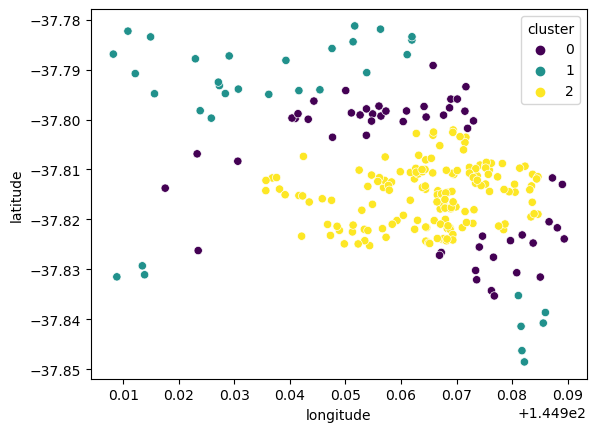

In [25]:
#clustering based on distances
kmeans = KMeans(n_clusters=3)
landmarks_df['cluster'] = kmeans.fit_predict(landmarks_df[['nearest_bus_distance', 'nearest_tram_distance', 'nearest_train_distance']])
sns.scatterplot(data=landmarks_df, x='longitude', y='latitude', hue='cluster', palette='viridis')
plt.show()

**Cluster Analysis**: Identified three clusters of landmarks based on accessibility:
  - **Cluster 0 (Purple)**: Landmarks with the lowest accessibility indices, indicating poor transport service.
  - **Cluster 1 (Green)**: Landmarks with moderate accessibility.
  - **Cluster 2 (Yellow)**: Landmarks with the highest accessibility, indicating well-served areas.

### Spatial Analysis

In [26]:
map_melbourne = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)
HeatMap(data=landmarks_df[['latitude', 'longitude', 'accessibility_index']], radius=15).add_to(map_melbourne)
map_melbourne.save('Accessibility_Heatmap.html')

In [27]:
map_melbourne.save('Accessibility_Heatmap.html')
IFrame(src='Accessibility_Heatmap.html', width=900, height=500)